<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/DataPreparation_S15A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive

In [0]:
# I have the images in 2 folders. One is background and the other image is the foreground image. 
# First I have to read the images. 

from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy the foreground and background images from drive

In [0]:
%mkdir /content/data
%cp -r /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15 /content/data

## Read the foreground and background images

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from statistics import mean

def showImages(images, cols=10, figSize=(15, 15)):
    """
    Shows images with its labels. Expected PIL Image. 
    """
    figure = plt.figure(figsize=figSize)
    num_of_images = len(images)
    rows = np.ceil(num_of_images / float(cols))
    for index in range(0, num_of_images):
        plt.subplot(rows, cols, index + 1)
        plt.axis('off')
        plt.imshow(np.asarray(images[index]), cmap="gray")

def getStats(images, name): 
  widths = [img.size[0] for img in images]
  heights = [img.size[1] for img in images]

  max_width = max(widths)
  max_height = max(heights)

  min_width = min(widths)
  min_height = min(heights)

  avg_width = mean(widths)
  avg_height = mean(heights)

  print(f"Number of images in {name}: {len(images)}")
  print(min_width, max_width, min_height, max_height)
  print(avg_width, avg_height)

Number of images in foreground: 109
13 310 63 356
184.90825688073394 220.3302752293578
Number of images in background: 110
100 342 100 300
231.84545454545454 196.3


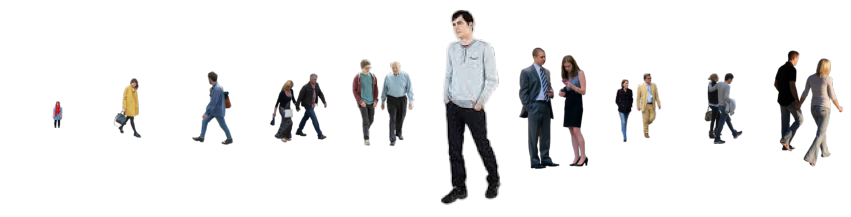

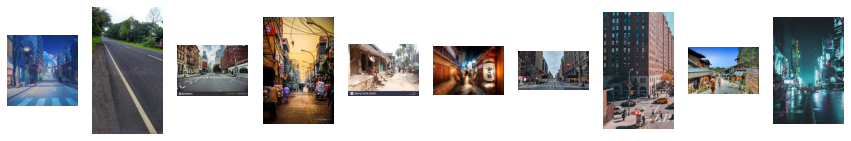

In [0]:
import cv2
from cv2 import imread
from os import listdir
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps

fg_images = [Image.open(join("/content/data/Assignment15/fg_images/", f)) for f in listdir("/content/data/Assignment15/fg_images/") if f != ".DS_Store"] 
bg_images = [Image.open(join("/content/data/Assignment15/bg_images/", f)) for f in listdir("/content/data/Assignment15/bg_images/") if f != ".DS_Store"]

getStats(fg_images, "foreground")
getStats(bg_images, "background")

showImages(fg_images[0:10], cols=10)
showImages(bg_images[0:10], cols=10)

## Preprocess the images 

*   Resize the background images to 224, 224
*   Resize the foreground images to 150, 150
*   Mirror the foreground images 
*   Create masks for the foreground images 





Number of images in foreground: 218
150 150 150 150
150 150
Number of images in background: 110
224 224 224 224
224 224


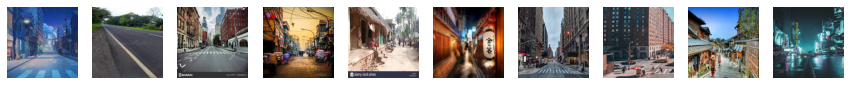

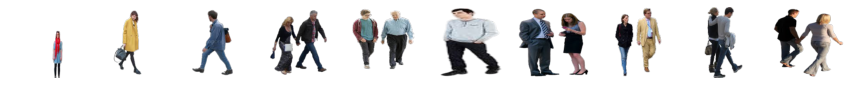

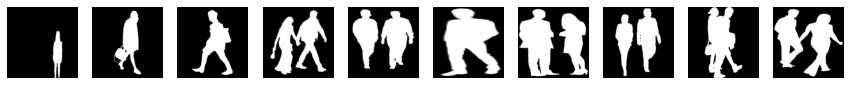

In [0]:
bg_images = [img.resize((224, 224)) for img in bg_images]
fg_images = [img.resize((150, 150)) for img in fg_images]
fg_flipped_images = [ImageOps.mirror(img) for img in fg_images]
fg_images = fg_images + fg_flipped_images
fg_mask_images = [img.split()[-1] for img in fg_images]

showImages(bg_images[0:10], cols=10)
showImages(fg_images[0:10], cols=10)
showImages(fg_mask_images[0:10], cols=10)

getStats(fg_images, "foreground")
getStats(bg_images, "background")

## Utility Functions

In [0]:

from PIL import ImageOps
from zipfile import ZipFile

def paste_fg_on_bg(bg, fg, fg_mask, count): 
    
    overlayed_images = []
    masked_images = []
    for i in range(count): 
        bg_width, bg_height = bg.size
        fg_width, fg_height = fg.size
        offset_x = np.random.randint(0, bg_width - fg_width)
        offset_y = np.random.randint(0, bg_height - fg_height)
        bg_copy = bg.copy() 
        bg_copy.paste(fg, (offset_x, offset_y), fg)
        overlayed_images.append(bg_copy)
        
        bg_mask = Image.new('1', bg.size)
        bg_mask.paste(fg_mask, (offset_x, offset_y), fg_mask)
        masked_images.append(bg_mask)

    return overlayed_images, masked_images

def persist(fg_bg_images, fg_bg_masks, start_name_idx, bg_fg_zip, bg_fg_mask_zip): 

    idx = start_name_idx
    for i, img in enumerate(fg_bg_images): 
      img.save("temp.jpg")
      bg_fg_zip.write("temp.jpg", f"fg_bg_image_{idx}.jpg")

      fg_bg_masks[i].save("mask_temp.jpg")
      bg_fg_mask_zip.write("mask_temp.jpg", f"fg_bg_mask_image_{idx}.jpg")

      idx += 1
    return idx 

def persistImagesToZip(images, folder, zipFile, startIdx=0, extn="jpg"): 

    names=[]
    for i, img in enumerate(images): 
      img.save(f"temp.{extn}")
      name = f"{folder}/Image_{startIdx + i}.{extn}"
      zipFile.write("temp.jpg", name)
      names.append(name)
    return names

def writeLabels(bg_file_name, fg_file_name, fg_bg_files, fg_bg_mask_files, labelFile): 
  for i in range(len(fg_bg_files)): 
    labelFile.write(f"{bg_file_name}\t{fg_file_name}\t{fg_bg_files[i]}\t{fg_bg_mask_files[i]}\n")

## Create the dataset 

In [0]:
from datetime import datetime

outputZip = ZipFile("data.zip", mode="a")

# write the bg images 
bg_image_files = persistImagesToZip(bg_images, "bg_images", outputZip)
fg_image_files = persistImagesToZip(fg_images, "fg_images", outputZip, extn="png")

labelsFile = open("labels.txt", "w")

# Generate images and add to the zip. 
count=0
for bg_idx, bg in enumerate(bg_images): 
  startTime = datetime.now()
  for fg_idx, fg in enumerate(fg_images):    
    fg_bg_images, fg_bg_masks = paste_fg_on_bg(bg, fg, fg_mask_images[fg_idx], 20)
    fg_bg_image_files = persistImagesToZip(fg_bg_images, "fg_bg", outputZip, count)
    fg_bg_mask_files = persistImagesToZip(fg_bg_masks, "fg_bg_mask", outputZip, count)    
    writeLabels(bg_image_files[bg_idx], fg_image_files[fg_idx], fg_bg_image_files, fg_bg_mask_files, labelsFile)
    count += len(fg_bg_image_files)
  print(f"Processed bg: {bg_idx + 1} image. Total image count: {count}. Time Taken: {datetime.now() - startTime}")
    
outputZip.close()
labelsFile.close()
print(count)

Processed bg: 1 image. Total image count: 4360. Time Taken: 0:00:15.838749
Processed bg: 2 image. Total image count: 8720. Time Taken: 0:00:16.505378
Processed bg: 3 image. Total image count: 13080. Time Taken: 0:00:17.069462
Processed bg: 4 image. Total image count: 17440. Time Taken: 0:00:17.577974
Processed bg: 5 image. Total image count: 21800. Time Taken: 0:00:17.473757
Processed bg: 6 image. Total image count: 26160. Time Taken: 0:00:16.902271
Processed bg: 7 image. Total image count: 30520. Time Taken: 0:00:17.682939
Processed bg: 8 image. Total image count: 34880. Time Taken: 0:00:17.289771
Processed bg: 9 image. Total image count: 39240. Time Taken: 0:00:17.863106
Processed bg: 10 image. Total image count: 43600. Time Taken: 0:00:16.675766
Processed bg: 11 image. Total image count: 47960. Time Taken: 0:00:17.351909
Processed bg: 12 image. Total image count: 52320. Time Taken: 0:00:19.816191
Processed bg: 13 image. Total image count: 56680. Time Taken: 0:00:17.357819
Processed 

## Copy the zip file to the drive 

In [0]:
%cp -r /content/data.zip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/
%cp /content/labels.txt /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/